In [ ]:
import os
import struct

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [7]:
#what are we looking at
vmax = 5 # FSR
components = 'x' # 'xy'

# read data on SD card

In [16]:
# Path to the SD card drive
sd_card_path = "D:\\"

# List all files in the SD card directory
files = os.listdir(sd_card_path)

# Print the files and display them as a list
print("Files on SD Card:")
for i, file in enumerate(files):
    print(f"{i + 1}: {file}")

Files on SD Card:
1: System Volume Information
2: 0_nogps_x_1.bin
3: 0_nogps_x_2.bin
4: 0_nogps_x_3.bin
5: 0_nogps_x_4.bin
6: 0_nogps_x_5.bin
7: 1_nogps_x_1.bin
8: 1_nogps_x_2.bin
9: 1_nogps_x_3.bin
10: 1_nogps_x_4.bin
11: 2_nogps_x_1.bin
12: 2_nogps_x_2.bin
13: 2_nogps_x_3.bin
14: 2_nogps_x_4.bin
15: 3_nogps_x_1.bin
16: 3_nogps_x_2.bin
17: 3_nogps_x_3.bin
18: 3_nogps_x_4.bin
19: 4_nogps_x_1.bin
20: 4_nogps_x_2.bin
21: 5_nogps_x_1.bin
22: 5_nogps_x_2.bin
23: 4_nogps_x_3.bin
24: 4_nogps_x_4.bin
25: 6_nogps_x_1.bin
26: 6_nogps_x_2.bin
27: 5_nogps_x_3.bin
28: 5_nogps_x_4.bin
29: 1_nogps_x_5.bin
30: 7_nogps_x_1.bin
31: 7_nogps_x_2.bin
32: 6_nogps_x_3.bin
33: 6_nogps_x_4.bin
34: 8_nogps_x_1.bin
35: 9_nogps_x_1.bin
36: 10_nogps_x_1.bin
37: 11_nogps_x_1.bin
38: 12_nogps_x_1.bin
39: 13_nogps_x_1.bin
40: 14_nogps_x_1.bin
41: 15_nogps_x_1.bin
42: 16_nogps_x_1.bin
43: 17_nogps_x_1.bin
44: 18_nogps_x_1.bin
45: 19_nogps_x_1.bin
46: 20_nogps_x_1.bin
47: 21_nogps_x_1.bin
48: 22_nogps_x_1.bin
49: 8_no

Metadata: {'GPS Latitude': 'N/A', 'GPS Longitude': 'N/A', 'GPS Timestamp (UTC)': 'N/A', 'Pico Time (us)': '16868514'}
Number of values replaced: 8
Average sample rate: 1018.0170125762382 Hz
Interpolated sample rate: 1016.8535615558073 Hz


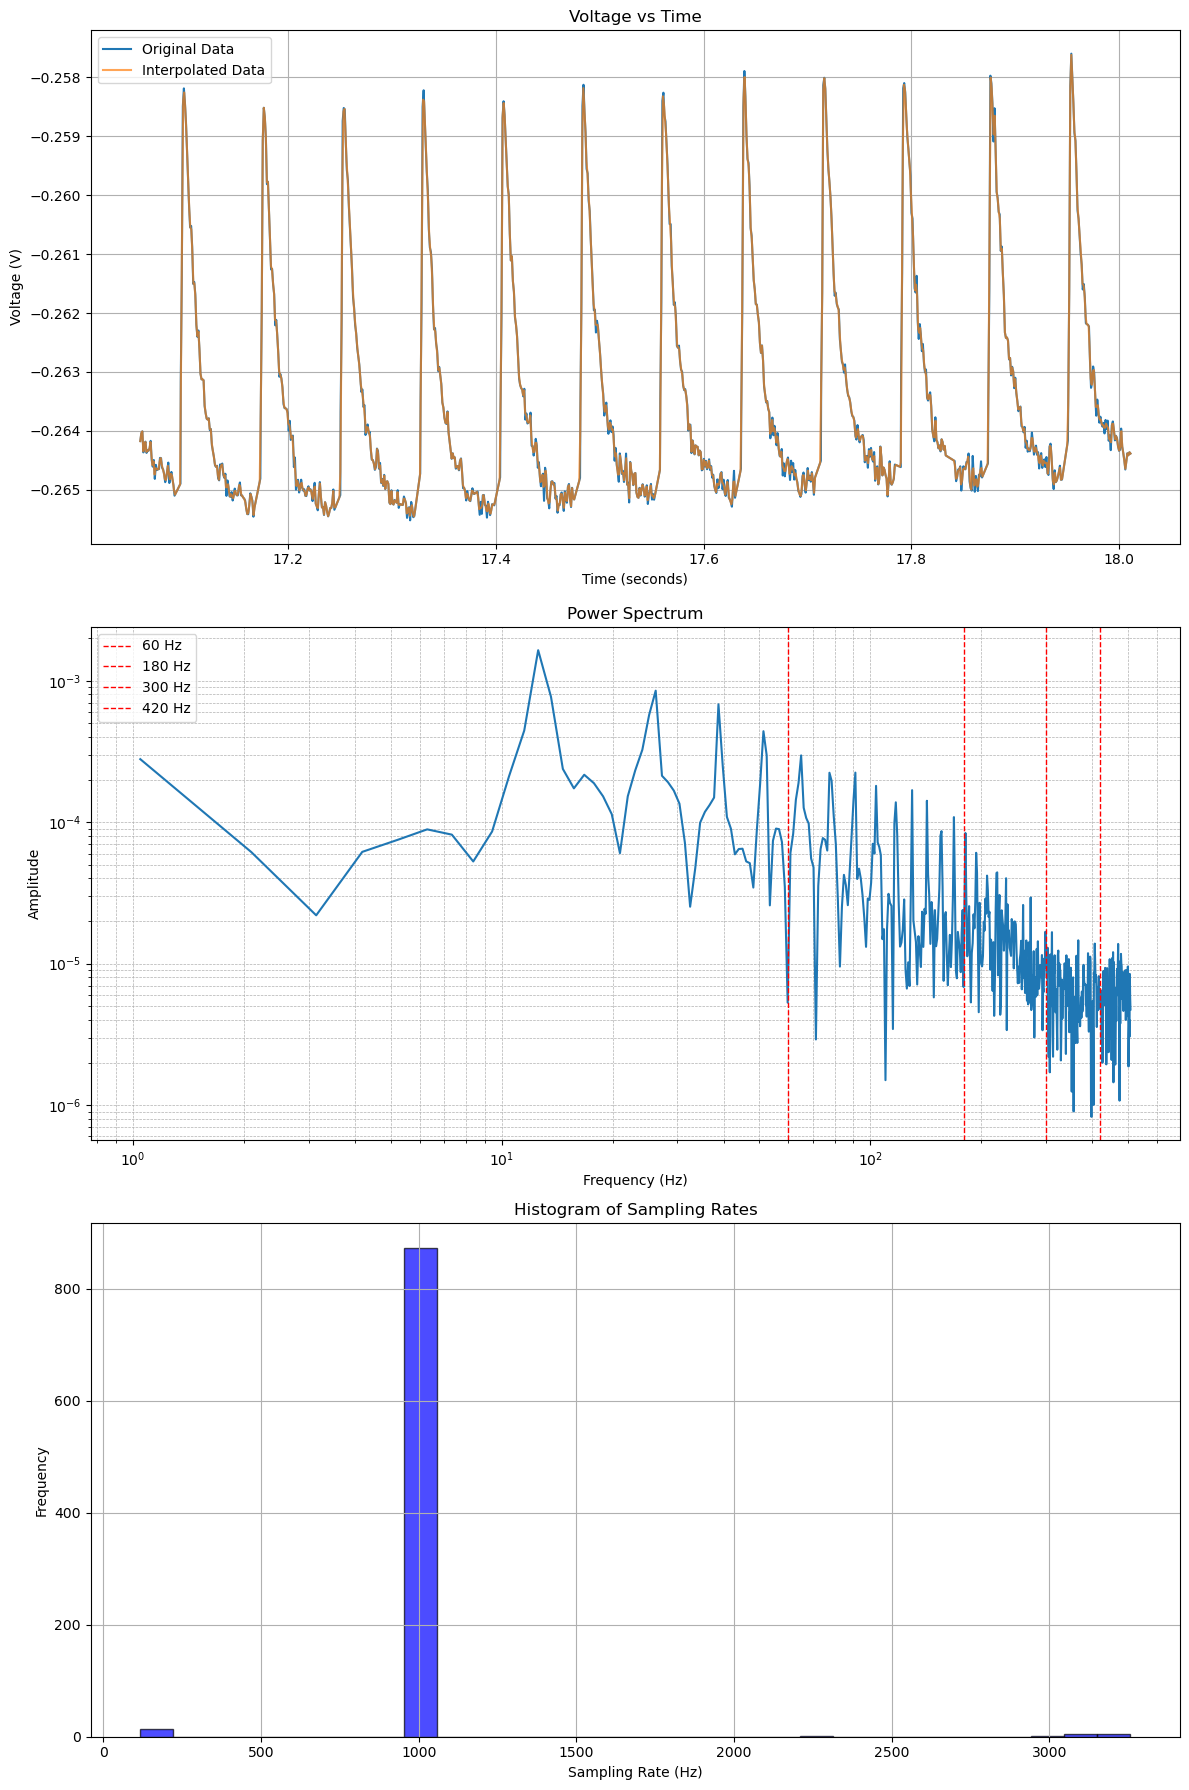

    V_int      t_us  sync         V          t
0 -443211  17057333     0 -0.264174  17.057333
1 -442985  17058327     0 -0.264040  17.058327
2 -442932  17059335     0 -0.264008  17.059335
3 -443532  17060330     0 -0.264366  17.060330
4 -443313  17061332     0 -0.264235  17.061332
PPS Flag occurrences:
sync
0    900
Name: count, dtype: int64


In [20]:
selected_file_index = 59  # User selects a file index (adjust as needed)

def read_metadata(file_path):
    metadata = {}
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if line == "Data:":
                break  # Stop at the "Data:" marker
            try:
                key, value = line.split(": ", 1)
                metadata[key.strip()] = value.strip()
            except ValueError:
                continue  # Handle lines that don't match key-value format
    return metadata

def read_binary_data_x(file_path, metadata_lines=5, sample_format='<3sI'):
    sample_size = struct.calcsize(sample_format)
    V_int_list = []
    t_us_list = []
    pps_flag_list = []
    
    with open(file_path, 'rb') as f:
        # Skip metadata lines
        for _ in range(metadata_lines):
            f.readline()
        
        # Read the binary data
        file_content = f.read()
        num_samples = len(file_content) // sample_size

        for i in range(num_samples):
            offset = i * sample_size
            sample_bytes = file_content[offset:offset + sample_size]
            if len(sample_bytes) < sample_size:
                print(f"Skipped incomplete sample at offset {offset}")
                continue
            try:
                raw_data, combined_time = struct.unpack(sample_format, sample_bytes)
                raw_int = int.from_bytes(raw_data, byteorder='big', signed=True)
                pps_flag = (combined_time >> 31) & 0x1
                sample_time = combined_time & 0x7FFFFFFF
                V_int_list.append(raw_int)
                t_us_list.append(sample_time)
                pps_flag_list.append(pps_flag)
            except struct.error as e:
                print(f"Error unpacking sample at index {i}: {e}")
                continue

    data = pd.DataFrame({
        'V_int': V_int_list,
        't_us': t_us_list,
        'sync': pps_flag_list
    })
    #data = remove_spikes(data, 'V_int')
    data = replace_spikes(data, 'V_int')
    return data

def remove_spikes(data, column, window=21, threshold_factor=3):
    
    if window % 2 == 0:
        raise ValueError("Window size must be odd for proper median calculation.")
    
    values = data[column].values
    rolling_median = pd.Series(values).rolling(window=window, center=True).median().values
    rolling_mad = pd.Series(values).rolling(window=window, center=True).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True).values

    to_remove = []

    for i in range(len(values)):
        if np.isnan(rolling_median[i]) or np.isnan(rolling_mad[i]):
            continue  # Skip edges where rolling calculations are NaN

        # Dynamic threshold using MAD
        lower_bound = rolling_median[i] - threshold_factor * rolling_mad[i]
        upper_bound = rolling_median[i] + threshold_factor * rolling_mad[i]

        if values[i] < lower_bound or values[i] > upper_bound:
            to_remove.append(i)

    # Print summary
    print(f"Number of rows removed: {len(to_remove)}")
    print(f"Indexes of removed rows: {to_remove}")

    # Drop rows by index
    data = data.drop(index=to_remove).reset_index(drop=True)
    
    return data

def replace_spikes(data, column, window=21, threshold_factor=3):
    if window % 2 == 0:
        raise ValueError("Window size must be odd for proper median calculation.")

    values = data[column].values
    rolling_median = pd.Series(values).rolling(window=window, center=True).median().values
    rolling_mad = pd.Series(values).rolling(window=window, center=True).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True).values

    replaced_count = 0

    for i in range(len(values)):
        if np.isnan(rolling_median[i]) or np.isnan(rolling_mad[i]):
            continue  # Skip edges where rolling calculations are NaN

        # Dynamic threshold using MAD
        lower_bound = rolling_median[i] - threshold_factor * rolling_mad[i]
        upper_bound = rolling_median[i] + threshold_factor * rolling_mad[i]

        if values[i] < lower_bound or values[i] > upper_bound:
            # Replace with the rolling median
            values[i] = rolling_median[i]
            replaced_count += 1

    # Print summary
    print(f"Number of values replaced: {replaced_count}")

    # Update the column in the DataFrame
    data[column] = values
    
    return data


def static_plots_x(t, interp_t, V, interp_V, freqs, amplitudes, sampling_rates):
    # Subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Voltage vs Time Plot
    axs[0].plot(t, V, label='Original Data')
    axs[0].plot(interp_t, interp_V, label='Interpolated Data', alpha=0.7)
    axs[0].set_xlabel("Time (seconds)")
    axs[0].set_ylabel("Voltage (V)")
    axs[0].grid(True)
    axs[0].set_title("Voltage vs Time")
    axs[0].legend()

    # Power Spectrum Plot
    axs[1].plot(freqs[1:], amplitudes[1:])
    axs[1].set_xscale("log")
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Amplitude")
    axs[1].axvline(60, color='red', linestyle='--', linewidth=1, label="60 Hz")
    axs[1].axvline(180, color='red', linestyle='--', linewidth=1, label="180 Hz")
    axs[1].axvline(300, color='red', linestyle='--', linewidth=1, label="300 Hz")
    axs[1].axvline(420, color='red', linestyle='--', linewidth=1, label="420 Hz")
    axs[1].grid(True, which="both", linestyle="--", linewidth=0.5)
    axs[1].set_title("Power Spectrum")
    axs[1].legend()

    # Sampling Rate Histogram
    axs[2].hist(sampling_rates, bins=30, color='blue', edgecolor='black', alpha=0.7)
    axs[2].set_xlabel("Sampling Rate (Hz)")
    axs[2].set_ylabel("Frequency")
    axs[2].grid(True)
    axs[2].set_title("Histogram of Sampling Rates")

    plt.tight_layout()
    plt.show()

selected_file = files[selected_file_index - 1]
file_path = os.path.join(sd_card_path, selected_file)

# Read metadata
metadata = read_metadata(file_path)
print("Metadata:", metadata)

# Read binary data
if components =='x':
    data = read_binary_data_x(file_path)
    n = 100
    data = data.iloc[n:].reset_index(drop=True)

    # Convert counts to voltage
    data['V'] = (data['V_int'] / (2**23)) * vmax

    # Convert time from microseconds to seconds
    data['t'] = data['t_us'] * 1e-6

    # Calculate sampling intervals and interpolate data
    t = data['t'].values
    V = data['V'].values
    dt = np.diff(t)
    sampling_rates = 1 / dt
    print('Average sample rate:', np.mean(sampling_rates), 'Hz')

        # Interpolate data
    nt = int((t[-1] - t[0]) * np.mean(sampling_rates))
    interp_t = np.linspace(t[0], t[-1], nt)
    interp_func = interp1d(t, V, kind='linear')
    interp_V = interp_func(interp_t)

    # FFT and plotting
    fft_values = np.fft.rfft(interp_V)
    amplitudes = (2 * np.abs(fft_values)) / len(interp_V)
    freqs = np.fft.rfftfreq(len(interp_t), d=(interp_t[1] - interp_t[0]))

    dt_interp = np.diff(interp_t)
    sampling_rates_interp = 1 / dt_interp
    print('Interpolated sample rate:', np.mean(sampling_rates_interp), 'Hz')

    static_plots_x(t, interp_t, V, interp_V, freqs, amplitudes, sampling_rates)


# Print the DataFrame
print(data.head())

# Print PPS occurrences
print("PPS Flag occurrences:")
print(data['sync'].value_counts())

